# Predicting Survivors of the Titanic Shipwreck

### Use machine learning to create a model that predicts which passengers survived the Titanic shipwreck.

### The Challenge

The sinking of the Titanic is one of the most infamous shipwrecks in history.

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

In this challenge, we will build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc)

### The Goal

The goal of this project is to predict if a passenger survived the sinking of the Titanic or not. For each in the test set, must predict a 0 or 1 value for the variable. 

### Datasets

There are two datasets that include passenger information like name, age, gender, socio-economic class, etc. One dataset is titled `train.csv` and the other is titled `test.csv`.

Train.csv will contain the details of a subset of the passengers on board (891 to be exact) and importantly, will reveal whether they survived or not, also known as the “ground truth”.

The `test.csv` dataset contains similar information but does not disclose the “ground truth” for each passenger. It’s your job to predict these outcomes.

Using the patterns you find in the train.csv data, predict whether the other 418 passengers on board (found in test.csv) survived.

# 1. Importing needed packages

In [1]:
pip install missingno

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Data Wrangling 
import pandas as pd
import numpy as np
import missingno
from collections import Counter

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Models
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

# Model Evaluation
from sklearn.model_selection import cross_val_score

# Hyperparameter tuning
from sklearn.model_selection import GridSearchCV

# Remove warnings 
import warnings 
warnings.filterwarnings('ignore')

%matplotlib inline

# 2. Reading the data in 

### Training Dataset

In [3]:
# read in the csv file
df1 = pd.read_csv('Data/train.csv')

df1.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Testing Dataset

In [4]:
# read in the csv file
df2 = pd.read_csv('Data/test.csv')

df2.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [5]:
# Dimensions of the training and testing datasets
print('Training set:',df1.shape)
print('Testing set:',df2.shape)

Training set: (891, 12)
Testing set: (418, 11)


# 3. Data Description

#### Description notes on some of the variables

 - Survived: Outcome of survival (0 = No; 1 = Yes)
 - Pclass: Socio-economic status describing ticket class (1 = Upper class, 2 = Middle class, 3 = Lower class)
 - Sib Sp: Number of siblings/spouses abroad
 - Parch: Number of parents/children abroad (0 if children travelled with nanny)
 - Embarked: Port of Embarkation (C = Cherbourg, Q = Queenstown, S = Southampton)

# 4. Exploratory Data Analysis (EDA)

The purpose of this section is to look and analyze the datasets given to help find useful insights for building a good machine learning model.   

## 4a. Summary statistics 

In [6]:
# In this summary we will find the data types and any missing values in the training and testing datasets
df1.info()
print('-------------')
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
-------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  

NOTE: We seem to have missing values in both datasets. Since both datasets are almost identical we have missing values in the same columns in both datasets. Let's take a look at those columns. 

In [7]:
# Missing values in training datasets
df1.isnull().sum().sort_values(ascending=False)

Cabin          687
Age            177
Embarked         2
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
SibSp            0
Parch            0
Ticket           0
Fare             0
dtype: int64

In [8]:
# Missing values in testing datasets
df2.isnull().sum().sort_values(ascending=False)

Cabin          327
Age             86
Fare             1
PassengerId      0
Pclass           0
Name             0
Sex              0
SibSp            0
Parch            0
Ticket           0
Embarked         0
dtype: int64

<AxesSubplot:>

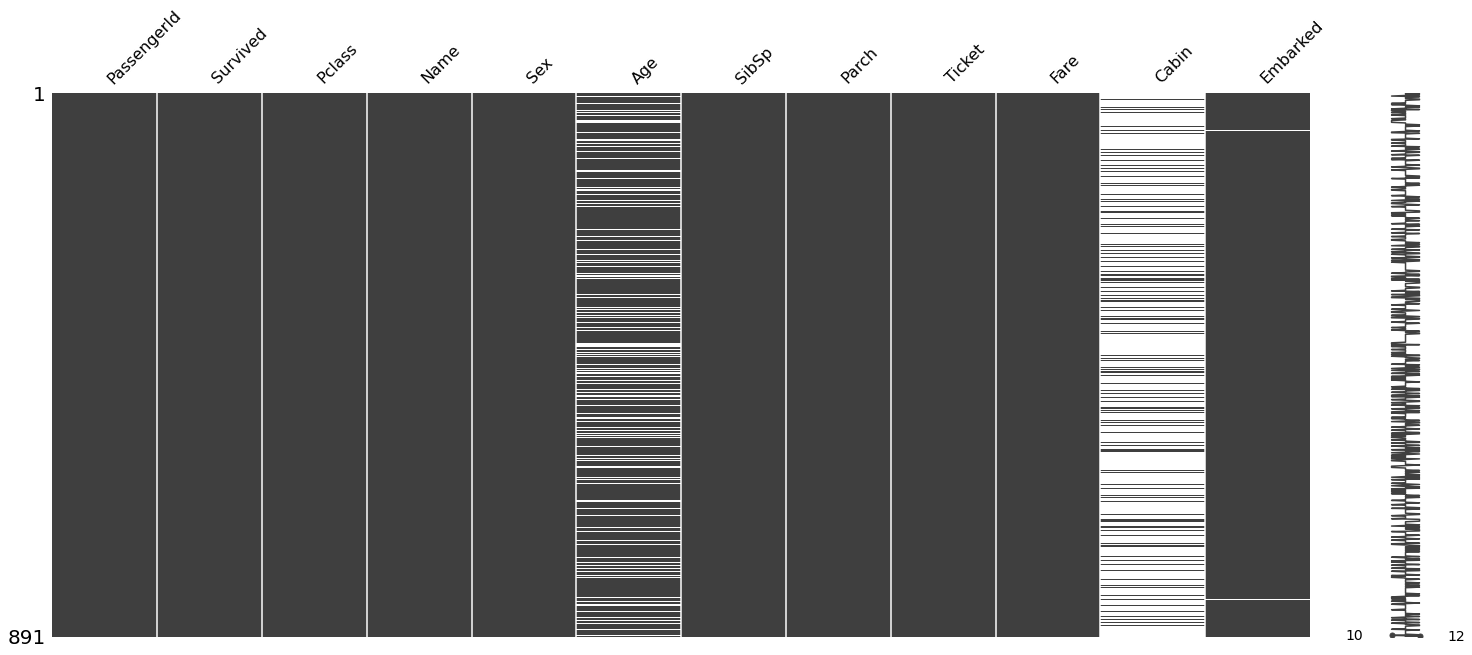

In [9]:
# visualization for missing values in training dataset
missingno.matrix(df1)

<AxesSubplot:>

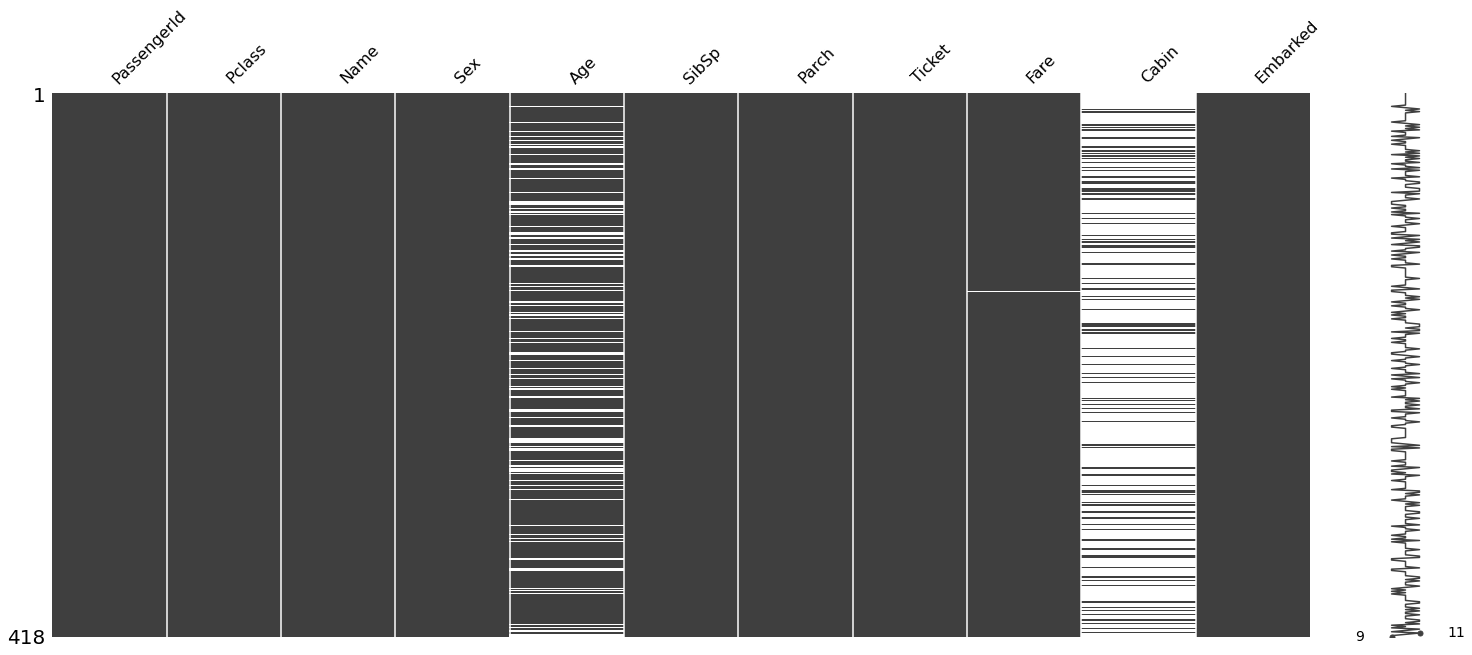

In [10]:
# visualization for missing values in testing dataset
missingno.matrix(df2)

Almost 80% of the values in the 'Cabin' column in the training set are missing. Will be interesting to see whether will impute these values or just remove this column from the training dataset. On the other hand, since the missing values in 'Age' and 'Embarked' columns are few will impute them. Will discuss the treatment of null values in the next section. 

In [11]:
# Another useful method, is the describe method which provides us with statistical data for our variables
# Summary statitics for training dataset
df1.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [12]:
# summary statitics for testing dataset
df2.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


## 4b. Feature Analysis

In this analysis section, we will compare more multiple features together and see which variables mostly relate to the rate of survival. In the training dataset, we have two types of variables: numeric and categoric. Therefore, we will analysze each type seperately. 

Before moving forward it is time now that we start to deal with the null values in the 'Cabin', 'Age' and 'Embarked' columns. We have previously found that there are 687 missing values out of 891. This accounts for more than 80% of the data included in the 'Cabin' column. Since this will affect our model and the predictions we will go ahead and remove this column. Although we could impute these missing values, however this may lead to overfitting and won't be a good estimate to the accuracy of our model. With regards to 'Age' and 'Embarked', will impute the missing values with the mean and mode respectively. The same feature analysis will be done for both datasets.

#### Training dataset

In [13]:
# dropping 'Cabin' column from training dataset
df1.drop('Cabin',axis=1,inplace=True)
# replacing null values in 'Age' column with mean
df1['Age'] = df1['Age'].fillna(df1['Age'].mean())
# replacicng null values in 'Age' column with median
# df1['Age'] = df1['Age'].fillna(df1['Age'].median())

In [14]:
# finding the mode value of 'Embarked' column
print(df1['Embarked'].mode())

0    S
dtype: object


In [15]:
# now we know the most common value 'S' is in index 0.
df1['Embarked'] = df1['Embarked'].fillna(df1['Embarked'].mode()[0])

In [16]:
# printing the training dataset after performing data cleaning
df1.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


In [17]:
# confirm there are no missing values
print('Missing values: {}\n'.format(df1.isna().any().any()))

Missing values: False



#### Testing dataset

In [18]:
# dropping 'Cabin' column from testing dataset
df2.drop('Cabin',axis=1,inplace=True)
# replacing null values in 'Age' column with mean
df2['Age'] = df2['Age'].fillna(df2['Age'].mean())
# replacicng null values in 'Age' column with median
# df2['Age'] = df2['Age'].fillna(df2['Age'].median())

In [19]:
# replacing null value in 'Fare' column with mean
df2['Fare'] = df2['Fare'].fillna(df2['Fare'].mean())
# replacicng null values in 'Age' column with median
# df2['Fare'] = df2['Fare'].fillna(df2['Fare'].median())

In [20]:
# finding the mode value of 'Embarked' column
print(df2['Embarked'].mode())

0    S
dtype: object


In [21]:
# now we know the most common value 'S' is in index 0.
df2['Embarked'] = df2['Embarked'].fillna(df2['Embarked'].mode()[0])

In [22]:
# printing the testing dataset after performing data cleaning
df2.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,S


In [23]:
# confirm there are no missing values
print('Missing values: {}\n'.format(df2.isna().any().any()))

Missing values: False



### 4.a.ii Feature Analysis on Categorical data

In [24]:
categ   =   df1[['Sex', 'Pclass', 'Embarked']]
numeric =   df1[['Age', 'Parch', 'SibSp', 'Fare']]

Since we are interested in knowing the rate of survival and are trying to predict predict who will survive we will be comparing the categorical variables with the 'Survived' feature to see how the survival rate was affected by the different demographic groups. 

It's first worth looking at the some staticrics regarding the surviving rate. 

In [25]:
# number of survivors during the titanic shipwreck
df1['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

The number of passengers who have not survived are more than those who survived. Around 60% of the passengers who were on the Titanic shipwreck have not survived. Let's now look at which sort of people have survived. 

#### 1st Categorical variable: Sex

In [26]:
# let's look at which gender survived most
df1['Sex'].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [27]:
# mean of survival by 'Sex'
pd.pivot_table(df1, index = 'Sex',values=['Survived'])

,Survived
Sex,
female,0.742038
male,0.188908


Text(0.5, 1.0, 'Survival rate by Gender')

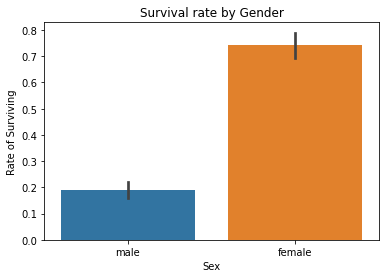

In [28]:
# let's visualise the relationship between surviving and sex
sns.barplot(x = 'Sex', y = 'Survived', data = df1)
plt.ylabel('Rate of Surviving')
plt.title('Survival rate by Gender')

There were 577 male passengers and 314 female passengers on the shipwreck. In addition to that, found out that female has a drastically higher mean of survival than male passengers. Although there were more male passengers, more female passengers managed to survived. Perhaps that could be because of female passengers taking care of children. Will find out as we go further in the analysis. 

#### 2nd Categorical variable: Pclass

In [29]:
# let's look at which class survived most
df1['Pclass'].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [30]:
# mean of survival by 'Pclass'
pd.pivot_table(df1, index = 'Pclass',values=['Survived'])

,Survived
Pclass,
1,0.629630
2,0.472826
3,0.242363


Text(0.5, 1.0, 'Survival rate by Class')

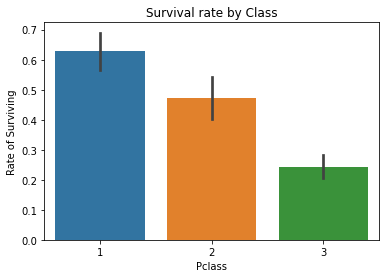

In [31]:
# let's visualise the relationship between surviving and sex
sns.barplot(x = 'Pclass', y = 'Survived', data = df1)
plt.ylabel('Rate of Surviving')
plt.title('Survival rate by Class')

Most of the passengers who were on the ship belong to the 3rd class. With almost half more than half of the passengers belong to that class. 1st class had 216 passengers and 2nd class had the least number with 184 passengers. 1st class passengers had the highest mean of survival followed by the 2nd class and the 3rd class passengers had the lowest mean of survival. A possible explaantion to this analysis is that since 1st passenger have paid higher fare for the ticket they have been prioritized over 2nd and 3rd class passengers. 

####  3rd Categorical variable: Embarked

In [32]:
# let's look at from which port did the passengers survive most
df1['Embarked'].value_counts()

S    646
C    168
Q     77
Name: Embarked, dtype: int64

In [33]:
# mean of survival by port of Embarkation
pd.pivot_table(df1, index = 'Embarked',values=['Survived'])

,Survived
Embarked,
C,0.553571
Q,0.389610
S,0.339009


Text(0.5, 1.0, 'Survival rate by port of embarkation')

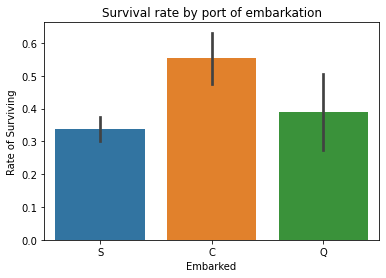

In [34]:
# let's visualise the relationship between surviving and port of embarkation
sns.barplot(x = 'Embarked', y = 'Survived', data = df1)
plt.ylabel('Rate of Surviving')
plt.title('Survival rate by port of embarkation')

Most of the passengers departed from port S, with 646 passengers departing from Southampton. 168 passengers departed from Cherbourg and only 77 departed from Queenstown. Those departed from port C had the highest mean of survival, these are expected to be 1st class passengers. Passengers from Queenstown have second higest rate of survival and passengers arriving from port S have lowest rate of survival. Again, these are expected to be 3rd class passengers. 

#### a. Combining multiple variables: Survived, Sex, Pclass

Text(30.160833333333343, 0.5, 'Survival rate')

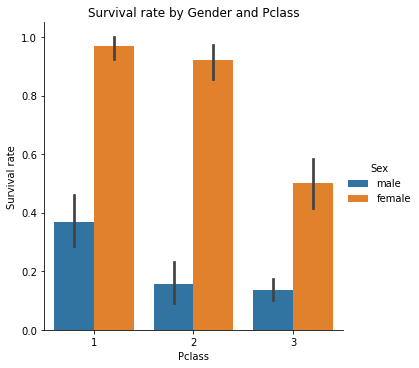

In [35]:
# Visualization of surviving by sex and pclass
sns.factorplot(x= "Pclass", y='Survived', hue= "Sex", data=df1 , kind = 'bar')
plt.title('Survival rate by Gender and Pclass')
plt.ylabel('Survival rate')

#### b. Combining multiple variables: Survived, Sex, Embarked

Text(30.160833333333343, 0.5, 'Survival rate')

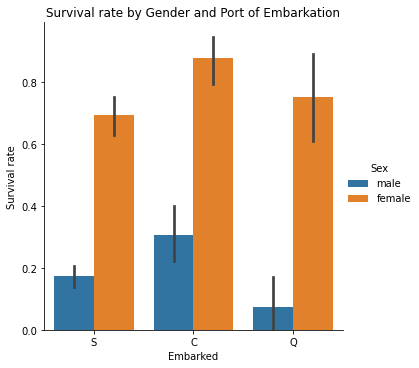

In [36]:
# Visualization of surviving by sex and port of embarkation
sns.factorplot(x= "Embarked", y='Survived', hue= "Sex", data=df1 , kind = 'bar')
plt.title('Survival rate by Gender and Port of Embarkation')
plt.ylabel('Survival rate')

#### c. Combining multiple variables: Survived, Pclass, Embarked

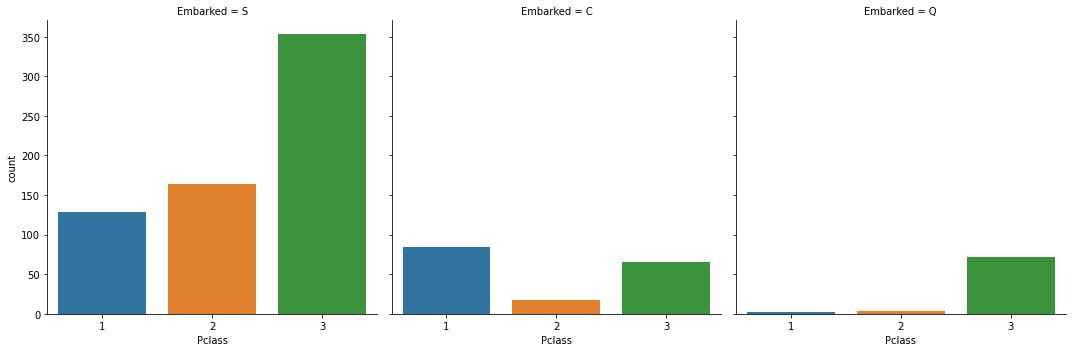

In [37]:
# Visualization of surviving by sex and port of embarkation
sns.factorplot("Pclass", col =  "Embarked", data=df1 , kind = 'count')

The reason why we combined more than one variable together is to see how early analysis come true. The graphs from combining variables proof that female passengers who have surived more than male passengers arrived from the port with the highest rate of survival(Port C). Also, latest graph have showed that passengers that came from the port that had the least rate of survival(Port S) are placed more in 3rd class. 

### 4.b.ii Feature Analysis on Numerical data

Will be doing the same analysis as we did with the categorical variables, checking how the numerical variables are compared to the survival rate. 

#### 1st Numerical variable: Age 

In [38]:
# let's look at which gender survived most
df1['Age'].describe()

count    891.000000
mean      29.699118
std       13.002015
min        0.420000
25%       22.000000
50%       29.699118
75%       35.000000
max       80.000000
Name: Age, dtype: float64

In [39]:
# comparing survival rate across age
pd.pivot_table(df1, index = 'Survived', values = ['Age'])

,Age
Survived,
0,30.415100
1,28.549778


<AxesSubplot:xlabel='Age', ylabel='Density'>

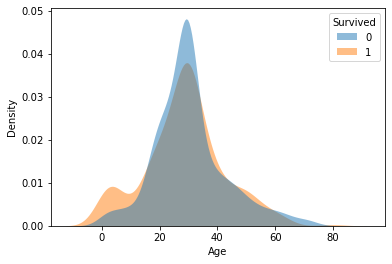

In [40]:
# Age disstribution 
sns.kdeplot( data=df1,  x = 'Age', hue = 'Survived',fill=True, common_norm=False,alpha=.5, linewidth=0,)

We can observe from the above analysis that the mean age of the passengers on the shipwreck was around 30 years old and had low chances of surviving. The average age of survivors was between 28 and 29 years old and can conclude that young passengers have higher survival rate. 

#### 2nd Numerical variable: Parch

In [41]:
# let's look at the Parch column which describes the number of parents/children 
# note (0 children travelled with nanny)
df1['Parch'].value_counts()

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

In [42]:
# mean of survival by considering parents and children
pd.pivot_table(df1, index = 'Parch',values=['Survived'])

,Survived
Parch,
0,0.343658
1,0.550847
2,0.500000
3,0.600000
4,0.000000
5,0.200000
6,0.000000


Text(0.5, 1.0, 'Survival rate by considering parents and children')

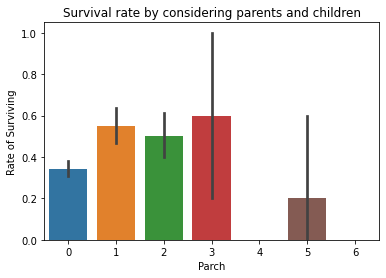

In [43]:
# let's visualise the relationship between surviving and 
sns.barplot(x = 'Parch', y = 'Survived', data = df1)
plt.ylabel('Rate of Surviving')
plt.title('Survival rate by considering parents and children')

#### 3rd Numerical variable: SibSp

In [44]:
# let's look at the SibSp column which describes the number of siblings/spouse
df1['SibSp'].value_counts()

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

In [45]:
# mean of survival by considering siblings and spouse
pd.pivot_table(df1, index = 'SibSp',values=['Survived'])

,Survived
SibSp,
0,0.345395
1,0.535885
2,0.464286
3,0.250000
4,0.166667
5,0.000000
8,0.000000


Text(0.5, 1.0, 'Survival rate by considering siblings and spouses')

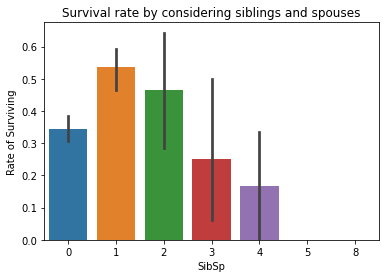

In [46]:
# let's visualise the relationship between surviving and SibSp
sns.barplot(x = 'SibSp', y = 'Survived', data = df1)
plt.ylabel('Rate of Surviving')
plt.title('Survival rate by considering siblings and spouses')

We can see from this relationship that those that have one or two sibling/spouse have higher mean of survival.

#### 4th Numerical variable: Fare

In [47]:
# let's look at the fare column
df1['Fare'].describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

In [48]:
# comparing survival rate across fare
pd.pivot_table(df1, index = 'Survived', values = ['Fare'])

,Fare
Survived,
0,22.117887
1,48.395408


<AxesSubplot:xlabel='Fare', ylabel='Density'>

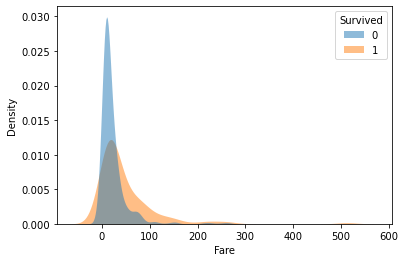

In [49]:
# Fare distribution
sns.kdeplot( data=df1,  x = 'Fare', hue = 'Survived',fill=True, common_norm=False,alpha=.5, linewidth=0,)

When accessing the Fare column, we can see that the average price for the ticket was 32 and that average paid for surviving was about 48. 

# 5. Data Preprocessing

Before we carry any preprocessing step will combine the training and testing dataset together. 

In [50]:
df1_2 = pd.concat([df1,df2], axis = 0).reset_index(drop=True)
df1_2.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


In [51]:
df1_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1309 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1309 non-null   float64
 10  Embarked     1309 non-null   object 
dtypes: float64(3), int64(4), object(4)
memory usage: 112.6+ KB


We will ignore the missing values in the survived column as they occur in the testing dataset and are the values we are tying to predict. 

In [52]:
df1_2.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


In this section, we will perform the followinig preprocessing steps: 
 - Drop unecessary columns (PassengerId and Ticket)
 - Perform feature engineering on 'Name' column
   - Extract 'Title' feature and create a new column named 'Title'
   - Drop 'Name' column
 - Convert 'Sex' column into numerical values, where 0=female and 1=male 
 - Encode Title and Embarked columns 
 - Group Age and Fare into segments
 - Create a new Column 'Family' that combines 'SibSp' and 'Parch'

In [53]:
# dropping unnecessary columns
df1_2.drop(columns = ['Ticket'], axis = 0, inplace = True)

In [54]:
# performing feature engineering on 'Name' column
# 1. Extracting Title from each name in 'Name' column 
df1_2['Title'] = df1.Name.apply(lambda x:x.split(',')[1].split('.')[0].strip())
df1_2.Title.value_counts()

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Major             2
Col               2
the Countess      1
Capt              1
Ms                1
Sir               1
Lady              1
Mme               1
Don               1
Jonkheer          1
Name: Title, dtype: int64

Will group the above Title names into 5 groups. It seems here that we have 4 main titles (Mr, Miss, Mrs, Master) and will group the other titles together and name that group 'Others'. 

In [55]:
# creating 'Others' group
df1_2['Title'] = df1_2['Title'].replace('Mlle','Miss')
df1_2['Title'] = df1_2['Title'].replace('Ms','Miss')
df1_2['Title'] = df1_2['Title'].replace('Mme','Mrs')
df1_2['Title'] = df1_2['Title'].replace(['Dr','Rev','Major','Col','the Countess','Capt','Sir','Lady','Don','Jonkheer'],'Others')

In [56]:
# the mean rate of survival after grouping the 'Title' column
pd.pivot_table(df1_2, index = 'Title', values = ['Survived'])

,Survived
Title,
Master,0.575000
Miss,0.702703
Mr,0.156673
Mrs,0.793651
Others,0.347826


We had previously shown that more women passengers have survived, and the above dataframe proves that. Passenger with 'Miss' and 'Mrs' Titles had higher survival rate. 

In [57]:
# dropping 'Name' column
df1_2.drop(columns = ['Name'], axis = 0, inplace = True)

In [58]:
# mapping 'Sex' column 
df1_2['Sex'] = df1_2['Sex'].map({'female':0, 'male':1}).astype(int)

In [59]:
# encode Title and Embarked columns
df1_2 = pd.get_dummies(df1_2, columns = ['Title'])
df1_2 = pd.get_dummies(df1_2, columns = ['Embarked'], prefix = 'Port')
df1_2.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Others,Port_C,Port_Q,Port_S
0,1,0.0,3,1,22.0,1,0,7.2500,0,0,1,0,0,0,0,1
1,2,1.0,1,0,38.0,1,0,71.2833,0,0,0,1,0,1,0,0
2,3,1.0,3,0,26.0,0,0,7.9250,0,1,0,0,0,0,0,1
3,4,1.0,1,0,35.0,1,0,53.1000,0,0,0,1,0,0,0,1
4,5,0.0,3,1,35.0,0,0,8.0500,0,0,1,0,0,0,0,1


#### Segmenting Age feature

Text(0.5, 1.0, 'Age Distribution')

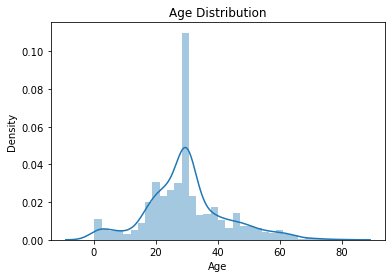

In [60]:
# viewing age distribuion 
sns.distplot(df1_2['Age'])
plt.title('Age Distribution')

In [61]:
# using cut method to determine the range of our segments
df1_2['AgeSeg'] = pd.cut(df1_2['Age'], 4)

In [62]:
# identfying the segments
df1_2['AgeSeg']

0       (20.128, 40.085]
1       (20.128, 40.085]
2       (20.128, 40.085]
3       (20.128, 40.085]
4       (20.128, 40.085]
              ...       
1304    (20.128, 40.085]
1305    (20.128, 40.085]
1306    (20.128, 40.085]
1307    (20.128, 40.085]
1308    (20.128, 40.085]
Name: AgeSeg, Length: 1309, dtype: category
Categories (4, interval[float64, right]): [(0.0902, 20.128] < (20.128, 40.085] < (40.085, 60.043] < (60.043, 80.0]]

In [63]:
# segmenting 'Age' feature
df1_2.loc[( df1_2.Age  <= 20.128) , 'Age'] = 0
df1_2.loc[( df1_2.Age  > 20.128 ) &   ( df1_2.Age <= 40.085), 'Age'] = 1
df1_2.loc[( df1_2.Age  > 40.085)  &   ( df1_2.Age <= 60.043),'Age'] = 2
df1_2.loc[( df1_2.Age  > 60.043)  &   ( df1_2.Age <= 80),    'Age'] = 3
df1_2.drop(columns = ['AgeSeg'], axis = 0, inplace=True)

#### Segmenting Fare feature

Text(0.5, 1.0, 'Fare Distribution')

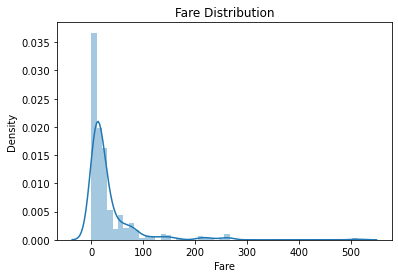

In [64]:
# viewing Fare distribuion 
sns.distplot(df1_2['Fare'])
plt.title('Fare Distribution')

In [65]:
# skewness of Fare distribution
df1_2['Fare'].skew()

4.369261051502992

As we can see from the graph above, 'Fare' distribution doesn't follow a normal distribution and has high skewness. Before segmenting this feature, we will reduce the skewness through log transformation

In [66]:
# applying log transformation to 'Fare' column 
df1_2['Fare'] = df1_2['Fare'].map(lambda x: np.log(x) if x > 0 else 0)
# skewness after log transformation
df1_2['Fare'].skew()

0.5673554293183874

Text(0.5, 1.0, 'Fare Distribution')

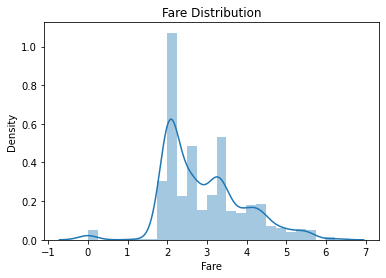

In [67]:
# viewing Fare distribuion 
sns.distplot(df1_2['Fare'])
plt.title('Fare Distribution')

In [68]:
# using cut method to determine the range of our segments
df1_2['FareSeg'] = pd.cut(df1_2['Fare'], 4)

In [69]:
# identfying the segments
df1_2['FareSeg']

0        (1.56, 3.119]
1       (3.119, 4.679]
2        (1.56, 3.119]
3       (3.119, 4.679]
4        (1.56, 3.119]
             ...      
1304     (1.56, 3.119]
1305    (4.679, 6.239]
1306     (1.56, 3.119]
1307     (1.56, 3.119]
1308     (1.56, 3.119]
Name: FareSeg, Length: 1309, dtype: category
Categories (4, interval[float64, right]): [(-0.00624, 1.56] < (1.56, 3.119] < (3.119, 4.679] < (4.679, 6.239]]

In [70]:
# dividing 'Fare' column into 4 segments
df1_2.loc[df1_2['Fare'] <= 1.56, 'Fare'] = 0
df1_2.loc[(df1_2['Fare'] > 1.56) & (df1_2['Fare'] <= 3.119), 'Fare'] = 1
df1_2.loc[(df1_2['Fare'] > 3.119) & (df1_2['Fare'] <= 4.679), 'Fare'] = 2
df1_2.loc[df1_2['Fare'] > 4.679, 'Fare'] = 3
df1_2.drop(columns = ['FareSeg'], axis = 0, inplace = True)

In [71]:
df1_2.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Others,Port_C,Port_Q,Port_S
0,1,0.0,3,1,1.0,1,0,1.0,0,0,1,0,0,0,0,1
1,2,1.0,1,0,1.0,1,0,2.0,0,0,0,1,0,1,0,0
2,3,1.0,3,0,1.0,0,0,1.0,0,1,0,0,0,0,0,1
3,4,1.0,1,0,1.0,1,0,2.0,0,0,0,1,0,0,0,1
4,5,0.0,3,1,1.0,0,0,1.0,0,0,1,0,0,0,0,1


#### Creating Family feature

In [72]:
# creating a new feature
df1_2['Family'] = df1_2['SibSp'] + df1_2['Parch'] +1 

In [73]:
df1_2['Family'].value_counts()

1     790
2     235
3     159
4      43
6      25
5      22
7      16
11     11
8       8
Name: Family, dtype: int64

In [74]:
# the mean rate of survival after creating 'Family feature'
pd.pivot_table(df1_2, index = 'Family', values = ['Survived'])

,Survived
Family,
1,0.303538
2,0.552795
3,0.578431
4,0.724138
5,0.200000
6,0.136364
7,0.333333
8,0.000000
11,0.000000


After creting 'Family' feature, we can see that 537 paassengers that were on the ship were alone. We will consider these passengers alone and combine all other passengers together. Will group the 537 passengers into group and name them 'Alone'. 

In [75]:
# creating 'Alone' group
df1_2['Alone']= 0
df1_2.loc[df1_2['Family'] == 1, 'Alone'] = 1

In [76]:
# drop 'SibSp','Parch', 'Family'
df1_2.drop(columns = ['SibSp','Parch', 'Family'], axis = 0, inplace =True)

In [77]:
df1_2.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Others,Port_C,Port_Q,Port_S,Alone
0,1,0.0,3,1,1.0,1.0,0,0,1,0,0,0,0,1,0
1,2,1.0,1,0,1.0,2.0,0,0,0,1,0,1,0,0,0
2,3,1.0,3,0,1.0,1.0,0,1,0,0,0,0,0,1,1
3,4,1.0,1,0,1.0,2.0,0,0,0,1,0,0,0,1,0
4,5,0.0,3,1,1.0,1.0,0,0,1,0,0,0,0,1,1


## Preparing the Datasets

Before creating any models, we need to split the concatenated dataset(df1_2) back into training and testing dataset. 

In [78]:
# spliting the combined dataset into training and testing datasets
train = df1_2[:len(df1)]
test  = df1_2[len(df1):]

In [79]:
train.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Others,Port_C,Port_Q,Port_S,Alone
0,1,0.0,3,1,1.0,1.0,0,0,1,0,0,0,0,1,0
1,2,1.0,1,0,1.0,2.0,0,0,0,1,0,1,0,0,0
2,3,1.0,3,0,1.0,1.0,0,1,0,0,0,0,0,1,1
3,4,1.0,1,0,1.0,2.0,0,0,0,1,0,0,0,1,0
4,5,0.0,3,1,1.0,1.0,0,0,1,0,0,0,0,1,1


In [80]:
# converting the 'Survived' column to integar datatype
train['Survived'] = train['Survived'].astype('int')
train.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Others,Port_C,Port_Q,Port_S,Alone
0,1,0,3,1,1.0,1.0,0,0,1,0,0,0,0,1,0
1,2,1,1,0,1.0,2.0,0,0,0,1,0,1,0,0,0
2,3,1,3,0,1.0,1.0,0,1,0,0,0,0,0,1,1
3,4,1,1,0,1.0,2.0,0,0,0,1,0,0,0,1,0
4,5,0,3,1,1.0,1.0,0,0,1,0,0,0,0,1,1


In [81]:
test.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Others,Port_C,Port_Q,Port_S,Alone
891,892,NaN,3,1,1.0,1.0,0,0,0,0,0,0,1,0,1
892,893,NaN,3,0,2.0,1.0,0,0,0,0,0,0,0,1,0
893,894,NaN,2,1,3.0,1.0,0,0,0,0,0,0,1,0,1
894,895,NaN,3,1,1.0,1.0,0,0,0,0,0,0,0,1,1
895,896,NaN,3,0,1.0,1.0,0,0,0,0,0,0,0,1,0


In [82]:
# dropping 'Survived' column from testing dataset
test.drop(columns = ['Survived'], axis=1, inplace = True)
test.head()

,PassengerId,Pclass,Sex,Age,Fare,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Others,Port_C,Port_Q,Port_S,Alone
891,892,3,1,1.0,1.0,0,0,0,0,0,0,1,0,1
892,893,3,0,2.0,1.0,0,0,0,0,0,0,0,1,0
893,894,2,1,3.0,1.0,0,0,0,0,0,0,1,0,1
894,895,3,1,1.0,1.0,0,0,0,0,0,0,0,1,1
895,896,3,0,1.0,1.0,0,0,0,0,0,0,0,1,0


# 6. Modelling

Machine learning models used in the project: 
 1. Logistic regression
 2. Support vector machines
 3. K-nearest neighbours
 4. Gaussian naive bayes
 5. Perceptron
 6. SVC
 7. Stochastic gradient descent
 8. Decision tree
 9. Random forest

### 6.1 Splitting datasets

In [83]:
# creating training and testing datasets 
X = train.drop(['Survived'], axis=1)
y = train['Survived']
print("X_train shape: ", X.shape)
print("y_train shape: ", y.shape)

X_train shape:  (891, 14)
y_train shape:  (891,)


### 6.2 Model Selection

In [84]:
# identyfing model names and parameters 
ml_models = {
    'DecisionTreeClassifier':{
        'model':DecisionTreeClassifier(),
        'param':{
            'criterion': ['gini','entropy'],
            'splitter' : ['best','random']
            
        }
    },
        'KNeighborsClassifier':{
        'model': KNeighborsClassifier(),
        'param':{
            'n_neighbors': [5,10,15,20,25,30,35],
            'weights'    : ['uniform','distance'],
            'algorithm'  : ['auto','ball_tree','kd_tree','brute']
        }
    },
        'SVC':{
        'model':SVC(),
        'param':{
            'kernel':['rbf','linear','sigmoid'],
            'C': [0.1, 1, 10, 100],
            'gamma': ['scale','auto']
        }
    },
    
        'Logistic Regression':{
        'model': LogisticRegression(),
        'param':{
            'C': [0.1, 1, 10, 100],
            'penalty':['l1','l2','elasticnet']
        }
    },
        'Random Forest Classifier':{
        'model': RandomForestClassifier(),
        'param':{
            'n_estimators': [100,200,300,400],
            'max_depth' : [2,4,6,8,10],
            'criterion': ['gini','entropy']
        }
            
    },   
             
        'Stochatic Gradient Descent Classifier':{
        'model': SGDClassifier(),
        'param':{
            'max_iter': [100,1000,10000],
            'penalty':['l1','l2','elasticnet']
         }
            
    },
             
        'Perceptron':{
        'model': Perceptron(),
        'param':{
            'alpha': [0.0001,0.001,0.01,0.1],
            'penalty':['l1','l2','elasticnet']
        }
            
    },
        
}

In [85]:
# creating a for loop to choose best model
results = []
for model_name, model_parameter in ml_models.items():
    MLmodel = GridSearchCV(estimator=model_parameter['model'],param_grid=model_parameter['param'],cv=5,return_train_score=False)
    MLmodel.fit(X,y)
    results.append({'MLmodels':model_name, 'Scores':MLmodel.best_score_, 'Selected Parameters':MLmodel.best_params_})

In [86]:
# creating a dataframe to store machine learning models and their best respective parameters 
df_mlmodels = pd.DataFrame(results,columns = ['MLmodels','Scores','Selected Parameters'])
df_mlmodels

,MLmodels,Scores,Selected Parameters
0,DecisionTreeClassifier,0.752031,"{'criterion': 'gini', 'splitter': 'best'}"
1,KNeighborsClassifier,0.583579,"{'algorithm': 'auto', 'n_neighbors': 35, 'weig..."
2,SVC,0.793484,"{'C': 1, 'gamma': 'scale', 'kernel': 'linear'}"
3,Logistic Regression,0.800232,"{'C': 1, 'penalty': 'l2'}"
4,Random Forest Classifier,0.822679,"{'criterion': 'entropy', 'max_depth': 6, 'n_es..."
5,Stochatic Gradient Descent Classifier,0.721694,"{'max_iter': 10000, 'penalty': 'l1'}"
6,Perceptron,0.618398,"{'alpha': 0.0001, 'penalty': 'elasticnet'}"


Our best machine learning models are Random Forest Classifier and SVC with a score of 0.826044 and 0.824926 respectively. We will proceed with Random Forest classifier as our best model. We will now train our best model with the selected parameters. 

In [87]:
# Parameters to use for our model
df_mlmodels.loc[4,'Selected Parameters']

{'criterion': 'entropy', 'max_depth': 6, 'n_estimators': 200}

In [88]:
# train the best model 
RFC = RandomForestClassifier(n_estimators=200, criterion='gini', max_depth=6)
RFC.fit(X,y)
Score = RFC.score(X,y)
Score

0.8597081930415263

By taking the best parameters into account, we can see that our score has improved for our model.

In [89]:
# Applying our model to the testing set to make predictions 
Predictions = RFC.predict(test)
Predictions

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0,
       1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0,

In [91]:
# storing the predictions in a dataframe to take a closer look at which passengers survived
Predict_passenger = pd.DataFrame({'PassengerId': test['PassengerId'],'Survived':Predictions})
Predict_passenger.head(10)

,PassengerId,Survived
891,892,0
892,893,0
893,894,0
894,895,0
895,896,0
896,897,0
897,898,0
898,899,0
899,900,1
900,901,0
